# Análise de Chamados do 1746 no Rio de Janeiro

Este notebook contém análises criativas baseadas nos dados de chamados do 1746 no Rio de Janeiro.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import basedosdados as bd
import os
from dotenv import load_dotenv

# Configurar o projeto de faturamento
load_dotenv()
billing_project_id = os.environ['billing_project_id']

# Função para executar queries
def run_query(query):
    return bd.read_sql(query, billing_project_id=billing_project_id)

## 1. Análise Temporal dos Chamados

Downloading: 100%|██████████|


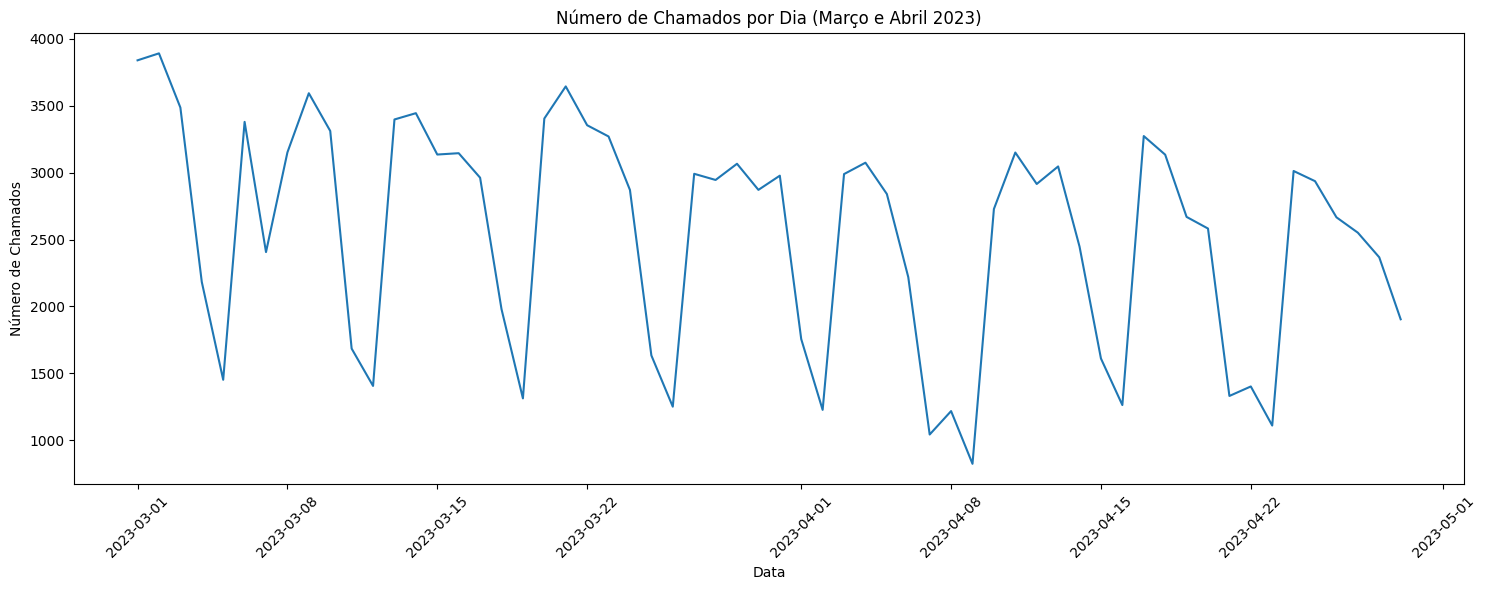

In [3]:
query = """
SELECT DATE(data_inicio) as data, COUNT(*) as total_chamados
FROM `datario.adm_central_atendimento_1746.chamado`
WHERE data_inicio BETWEEN '2023-03-01' AND '2023-04-30'
GROUP BY data
ORDER BY data
"""

df_temporal = run_query(query)

plt.figure(figsize=(15, 6))
plt.plot(df_temporal['data'], df_temporal['total_chamados'])
plt.title('Número de Chamados por Dia (Março e Abril 2023)')
plt.xlabel('Data')
plt.ylabel('Número de Chamados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Distribuição de Tipos de Chamados

Downloading: 100%|██████████|


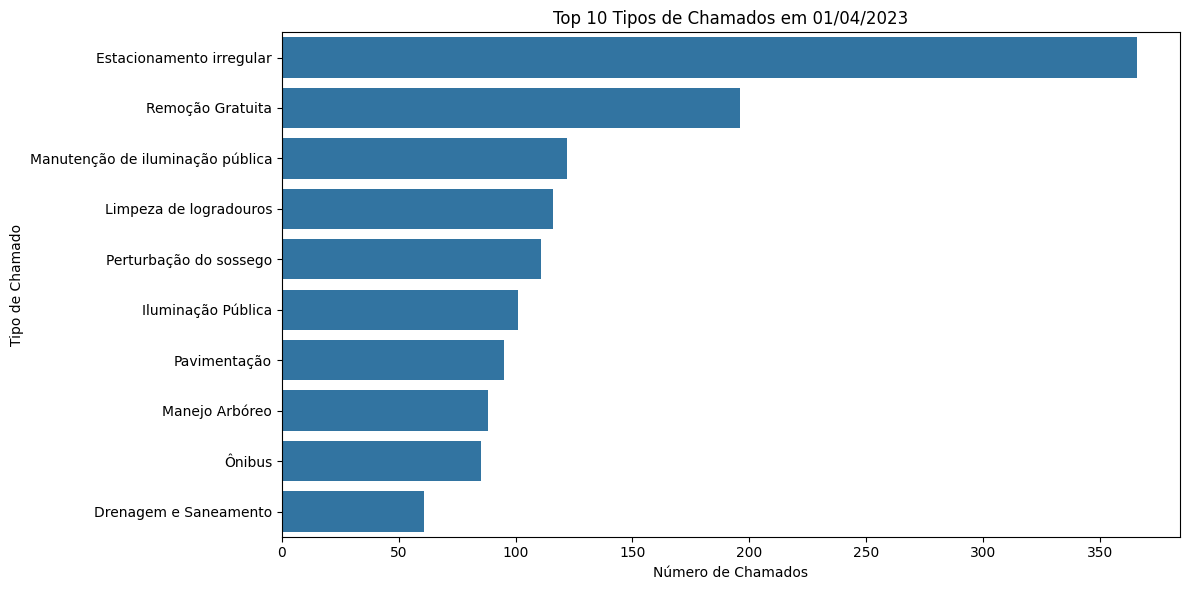

In [4]:
query = """
SELECT tipo, COUNT(*) as total_chamados
FROM `datario.adm_central_atendimento_1746.chamado`
WHERE DATE(data_inicio) = '2023-04-01'
GROUP BY tipo
ORDER BY total_chamados DESC
LIMIT 10
"""

df_tipos = run_query(query)

plt.figure(figsize=(12, 6))
sns.barplot(x='total_chamados', y='tipo', data=df_tipos)
plt.title('Top 10 Tipos de Chamados em 01/04/2023')
plt.xlabel('Número de Chamados')
plt.ylabel('Tipo de Chamado')
plt.tight_layout()
plt.show()

## 3. Mapa de Calor dos Chamados por Bairro

Downloading: 100%|██████████|


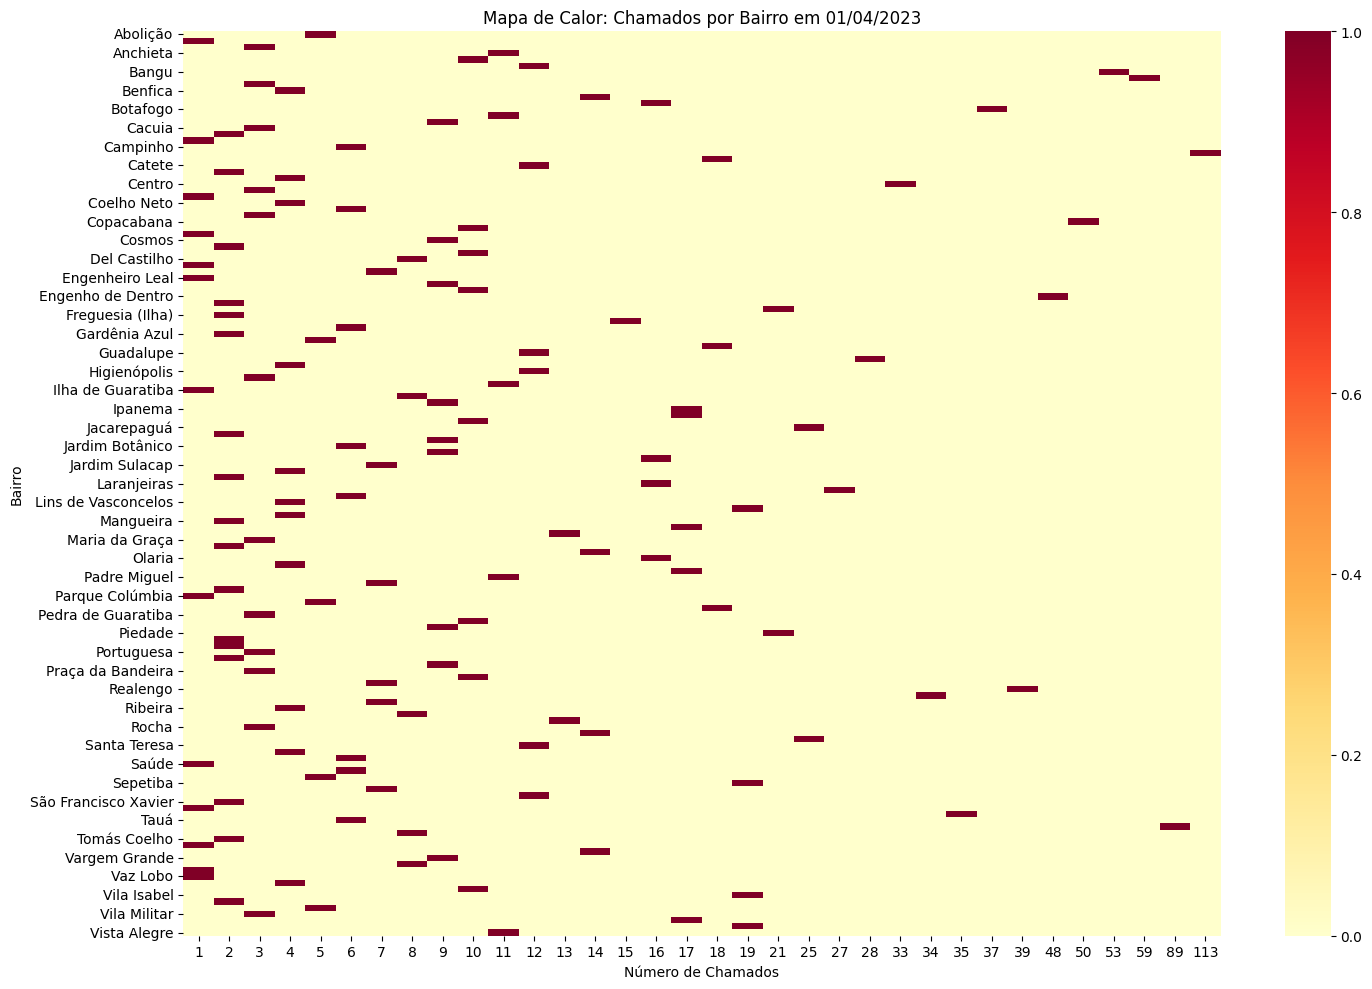

In [8]:
query = """
SELECT b.nome as bairro, COUNT(*) as total_chamados
FROM `datario.adm_central_atendimento_1746.chamado` c
JOIN `datario.dados_mestres.bairro` b ON c.id_bairro = b.id_bairro
WHERE DATE(c.data_inicio) = '2023-04-01'
GROUP BY b.nome
ORDER BY total_chamados DESC
"""

df_bairros = run_query(query)

# Convert total_chamados to integer if it's not already
df_bairros['total_chamados'] = df_bairros['total_chamados'].astype(int)

# Create a pivot table
pivot_data = df_bairros.pivot_table(values='total_chamados', 
                                  index='bairro', 
                                  columns='total_chamados', 
                                  aggfunc='size', 
                                  fill_value=0)

# Sort the index and columns
pivot_data = pivot_data.sort_index()
pivot_data = pivot_data.sort_index(axis=1)

plt.figure(figsize=(15, 10))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=False)
plt.title('Mapa de Calor: Chamados por Bairro em 01/04/2023')
plt.xlabel('Número de Chamados')
plt.ylabel('Bairro')
plt.tight_layout()
plt.show()

## 4. Análise de Sazonalidade da Perturbação do Sossego

Downloading: 100%|██████████|


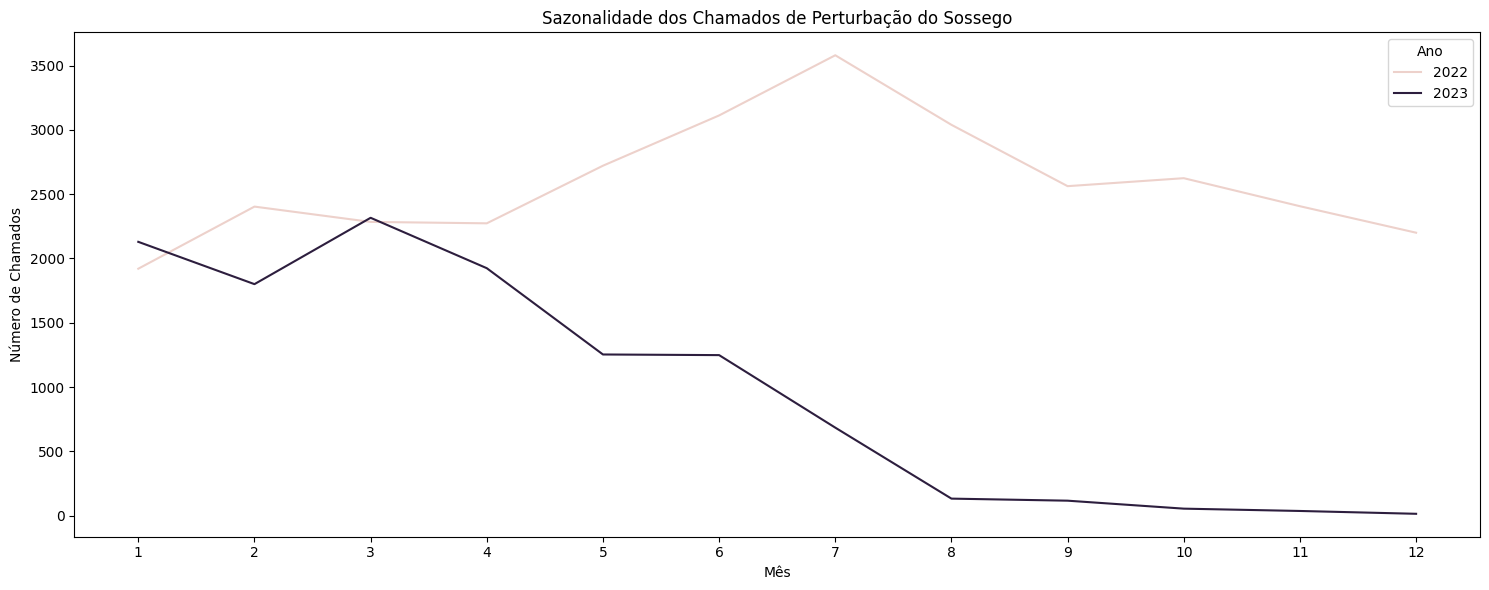

In [9]:
query = """
SELECT EXTRACT(MONTH FROM data_inicio) as mes, 
       EXTRACT(YEAR FROM data_inicio) as ano,
       COUNT(*) as total_chamados
FROM `datario.adm_central_atendimento_1746.chamado`
WHERE subtipo = 'Perturbação do sossego'
  AND data_inicio BETWEEN '2022-01-01' AND '2023-12-31'
GROUP BY mes, ano
ORDER BY ano, mes
"""

df_sazonalidade = run_query(query)

plt.figure(figsize=(15, 6))
sns.lineplot(x='mes', y='total_chamados', hue='ano', data=df_sazonalidade)
plt.title('Sazonalidade dos Chamados de Perturbação do Sossego')
plt.xlabel('Mês')
plt.ylabel('Número de Chamados')
plt.xticks(range(1, 13))
plt.legend(title='Ano')
plt.tight_layout()
plt.show()

## 5. Comparação de Eventos: Perturbação do Sossego

Downloading: 100%|██████████|


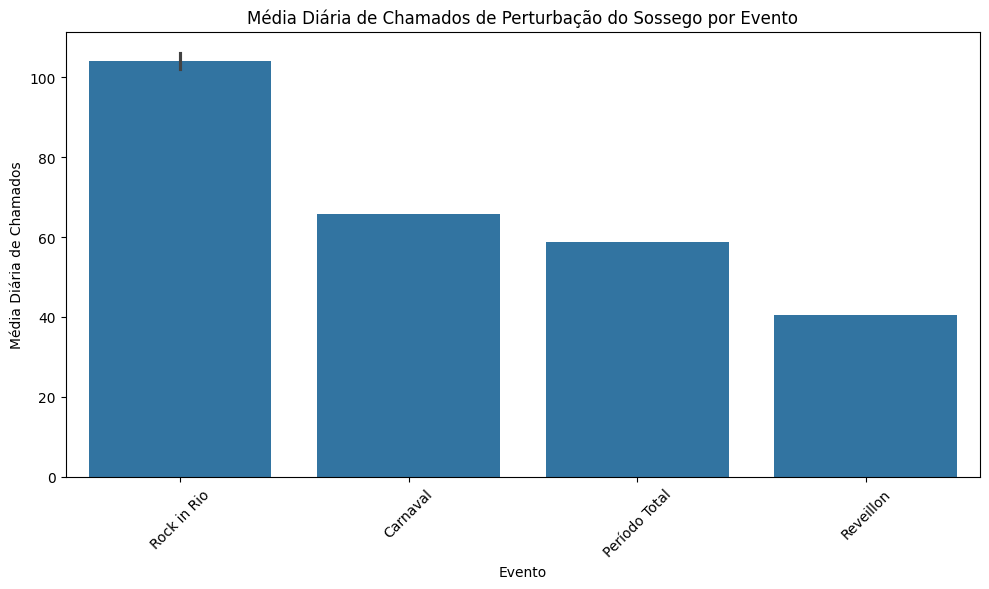

In [14]:
query = """
WITH eventos_media AS (
  SELECT e.evento, 
         COUNT(*) / DATE_DIFF(e.data_final, e.data_inicial, DAY) as media_diaria_chamados
  FROM `datario.adm_central_atendimento_1746.chamado` c
  JOIN `datario.turismo_fluxo_visitantes.rede_hoteleira_ocupacao_eventos` e
    ON c.data_inicio BETWEEN e.data_inicial AND e.data_final
  WHERE c.subtipo = 'Perturbação do sossego'
    AND e.evento IN ('Reveillon', 'Carnaval', 'Rock in Rio')
  GROUP BY e.evento, e.data_inicial, e.data_final
),
periodo_total_media AS (
  SELECT COUNT(*) / 730 as media_diaria_chamados  -- 730 dias entre 01/01/2022 e 31/12/2023
  FROM `datario.adm_central_atendimento_1746.chamado`
  WHERE subtipo = 'Perturbação do sossego'
    AND data_inicio BETWEEN '2022-01-01' AND '2023-12-31 23:59:59'
)
SELECT 'Período Total' as periodo, media_diaria_chamados
FROM periodo_total_media
UNION ALL
SELECT evento, media_diaria_chamados
FROM eventos_media
ORDER BY media_diaria_chamados DESC
"""

df_eventos = run_query(query)

plt.figure(figsize=(10, 6))
sns.barplot(x='periodo', y='media_diaria_chamados', data=df_eventos)
plt.title('Média Diária de Chamados de Perturbação do Sossego por Evento')
plt.xlabel('Evento')
plt.ylabel('Média Diária de Chamados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusões

1. A análise temporal mostra variações no número de chamados ao longo do tempo, o que pode estar relacionado a eventos específicos ou padrões sazonais.

2. A distribuição de tipos de chamados revela as principais preocupações dos cidadãos, com 'Estacionamento irregular' sendo o mais frequente.

3. O mapa de calor dos chamados por bairro destaca as áreas da cidade que requerem mais atenção, com Campo Grande, Tijuca e Barra da Tijuca liderando.

4. A análise de sazonalidade da perturbação do sossego pode revelar padrões mensais ou anuais, possivelmente relacionados a férias ou eventos sazonais.

5. A comparação de eventos mostra que o Rock in Rio tem o maior impacto na média diária de chamados de perturbação do sossego, seguido pelo Carnaval.

Estas análises fornecem insights valiosos para o planejamento urbano e a alocação de recursos, permitindo uma resposta mais eficaz às necessidades dos cidadãos.